# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Bernat Quintilla Castellón</font>

E-mail: <font color="blue">bernat.quintilla01@estudiant.upf.edu</font>

Date: <font color="blue">08/11/2023</font>

# 0. The Movies dataset

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). In this assignment we are going to use the 25M version, which was released in late 2019.

We will use a sub-set containing only movies released in the 2000s, and only 20% of the users and all of their ratings.

**MOVIES** are described in `movies-2000s.csv` in the following format: `movieId,title,genres`.

- Titles include the year of release in paranthesis, the year is greater or equal to 2000
- Genres are pipe-separated ("|") and are selected from the following genres: 'Musical', 'Horror', 'Comedy', 'Crime', 'Western', 'Sci-Fi', 'Documentary', 'Adventure', 'IMAX', 'Drama', 'Fantasy', 'Children', 'War', 'Thriller', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Animation' or '(no genres listed)'.

**RATINGS** are contained in `ratings-2000s.csv` in the following format: `userId,movieId,rating`

- Ratings are made on a 5-star scale
- This has been filtered to contain only movies released in the 2000s, and to sample 20% of rows

**TAGS** are contained in `tags-2000s.csv` in the following format: `userId,movieId,tag,timestamp`

- Tags are words or short phrases, they are user-generated and can be anything
- Timestamp is represented in seconds since the epoch as returned by time(2).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [1]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
#%pip install wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

The following code, which you should leave as-is, loads the 3 dataset within three dataframes named `movies`,  `ratings` and `tags` considering the data structure explained above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [3]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


Next we will add a column named "year" to the `movies` dataset.

First, create a function `yearof()` that returns the year of a title as an integer, for instance:

```python
print(yearof("The Emoji Movie (2017)"))
```

Should return the integer *2017*. Then, you can apply this function to the entire dataframe.

If you have a function named *f* that takes the column *a* of dataframe *df*, and produces a value you want to store in column *b* of the same dataframe, you can use:

```python
df['b'] = df.apply(lambda x: f(x['a']), axis=1)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [4]:
def yearof(title):
    try:
        year = int(title.split("(")[-1].split(")")[0])
        return year
    except ValueError:
        return None
movies['year'] = movies.apply(lambda x: yearof(x['title']),axis=1)
movies.head()

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


Next we will join the dataframes into a single dataframe named "ratings". The equivalent of a database join is done with [pandas.merge](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) in Pandas, and it requires to identify common columns between the inputs that need to be joined. You can use:

```python
a = pd.merge(b, c, how='inner', on='...')
```

There the `on` parameter should indicate the name of the column in common between `b` and `c`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and users, and on which field you can join ratings_raw and movies.</font>

On one hand the field I would use to join ratings_raw and users is the ```user_id```, and on the other hand I would use the field ```movie_id``` to join rating_raws and movies.

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genders, year</font>

In [5]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')
ratings.head()

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


Create a function `find_movies` to easily find movies that contain a given keyword in its title. For instance `find_movies("Friday", movies)` should print:

```
movie_id:  3177, title: Next Friday (2000)
movie_id:  5874, title: Friday After Next (2002)
movie_id:  6593, title: Freaky Friday (2003)
movie_id:  7880, title: Friday Night (Vendredi Soir) (2002)
movie_id:  8937, title: Friday Night Lights (2004)
movie_id: 66783, title: Friday the 13th (2009)
movie_id: 97175, title: His Name Was Jason: 30 Years of Friday the 13th (2009)
movie_id: 121113, title: Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie_id: 133699, title: Black Friday (2004)
movie_id: 134649, title: Bad Hair Friday (2012)
movie_id: 161157, title: Friday (Pyatnitsa) (2016)
movie_id: 171951, title: Monster High: Friday Night Frights (2013)
movie_id: 192411, title: Freaky Friday (2018)
movie_id: 197903, title: Seven Days: Friday - Sunday (2015)
```

*Tip:* to know if string *a* is contained in string *b*, you can ask `if a in b`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [6]:
def find_movies(keyword, movies):
    found_movies = []

    for index, row in movies.iterrows():
        if keyword in row['title']:
            found_movies.append((row['movie_id'], row['title']))

    for movie_id, title in found_movies:
        print(f"movie_id: {movie_id}, title: {title}")

find_movies("Friday", movies)

movie_id: 3177, title: Next Friday (2000)
movie_id: 5874, title: Friday After Next (2002)
movie_id: 6593, title: Freaky Friday (2003)
movie_id: 7880, title: Friday Night (Vendredi Soir) (2002)
movie_id: 8937, title: Friday Night Lights (2004)
movie_id: 66783, title: Friday the 13th (2009)
movie_id: 97175, title: His Name Was Jason: 30 Years of Friday the 13th (2009)
movie_id: 121113, title: Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie_id: 133699, title: Black Friday (2004)
movie_id: 134649, title: Bad Hair Friday (2012)
movie_id: 161157, title: Friday (Pyatnitsa) (2016)
movie_id: 171951, title: Monster High: Friday Night Frights (2013)
movie_id: 192411, title: Freaky Friday (2018)
movie_id: 197903, title: Seven Days: Friday - Sunday (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [7]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

It is key to know how ratings are distributed. Generate a plot with the ditribution of the ratings. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

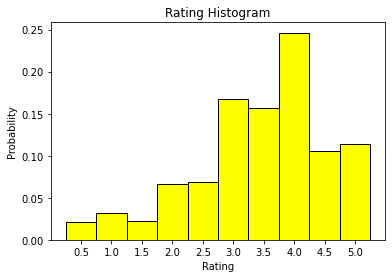

In [8]:
rating_counts = ratings['rating'].value_counts(normalize=True).sort_index()

plt.bar(rating_counts.index, rating_counts.values, width = 0.5, edgecolor='black', color='yellow')

plt.xlabel("Rating")
plt.ylabel("Probability")
plt.title("Rating Histogram")
plt.xticks(rating_counts.index)

plt.show()

<font size="+1" color="red">Replace this cell with your code to plot a boxplot of ratings. Look for outlier values. </font>

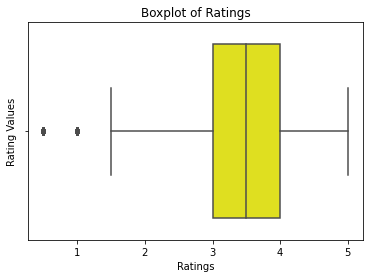

In [9]:
sns.boxplot(x=ratings['rating'],color = 'yellow')

plt.xlabel("Ratings")
plt.ylabel("Rating Values")
plt.title("Boxplot of Ratings")

plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

I observe that the majority of ratings are beetween 3 and 4, and only a few are above or under this interval. This statement makes sense because only if a film is extraordinary good or bad will have that extreme ratings. And there are much more average films than the ones that recieve that rating. In the boxplot we can see how the ratings below 1.5 are so unlikely to be given to a film that we can also count those ratings as outliers.

Now let us find out two extrema: movies with many good ratings and movies with many bad ratings.

For this, a good idea is to find create a different dataframe. For instance, you can create `good_ratings`, containing only the subset of rows of `ratings` that has *rating > 4.0*, and `bad_ratings` containing only the subset that has *rating < 2.0*.

Then, you just need to count what are the most frequent titles in `good_ratings`. There are many ways to do this, one is by using [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [nlargest](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html), but there are other ways.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 2.0)</font>

In [10]:
good_ratings = ratings[ratings['rating'] > 4.0]
bad_ratings = ratings[ratings['rating'] < 2.0]

most_frequent_good_titles = good_ratings['movie_id'].value_counts().nlargest(10)
most_frequent_bad_titles = bad_ratings['movie_id'].value_counts().nlargest(10)

print("Movies with Many Good Ratings:")
for movie_id, count in most_frequent_good_titles.iteritems():
    movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
    print(f"Title: {movie_title}, Count: {count}")

print("\nMovies with Many Bad Ratings:")
for movie_id, count in most_frequent_bad_titles.iteritems():
    movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
    print(f"Title: {movie_title}, Count: {count}")

Movies with Many Good Ratings:
Title: Lord of the Rings: The Fellowship of the Ring, The (2001), Count: 3017
Title: Lord of the Rings: The Return of the King, The (2003), Count: 2792
Title: Lord of the Rings: The Two Towers, The (2002), Count: 2690
Title: Memento (2000), Count: 2184
Title: Gladiator (2000), Count: 1835
Title: Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001), Count: 1801
Title: Eternal Sunshine of the Spotless Mind (2004), Count: 1711
Title: Spirited Away (Sen to Chihiro no kamikakushi) (2001), Count: 1378
Title: Kill Bill: Vol. 1 (2003), Count: 1360
Title: Shrek (2001), Count: 1311

Movies with Many Bad Ratings:
Title: Charlie's Angels (2000), Count: 338
Title: Battlefield Earth (2000), Count: 317
Title: Scary Movie (2000), Count: 296
Title: Star Wars: Episode II - Attack of the Clones (2002), Count: 274
Title: Mission: Impossible II (2000), Count: 244
Title: American Pie 2 (2001), Count: 227
Title: Lord of the Rings: The Fellowship of the Ring, The (2001), Count:

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

In these lists I can observe that some popular films have the best and the worst ratings at the same time. This can be produced due to the variety of opinions of that film, even if the film has a high rating overall. One case of this phenomenom are the Lord of the Rings films as we can see in the lists. In conclusion even if the film is extraordinary it can have bad ratings because depends of the taste of each critic. Because of that is better to compare film computing the overall rating of each film.

## 2.2. Genres distribution

Tipically, a movie genre (e.g., "musical", "action", "romance") is one of the most important descriptor for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. Because of this, we have to know how this variable is, i.e. the values or categories, number or ratio of each categories, and so on.

Create a table indicating the list of all genres (column `movie['genres']` in this dataset).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 20 genres with an assert, as follows:
    assert(n == 20).</font>

In [11]:
genres_column = movies['genres']

all_genres = set()
for genres in genres_column:
    genre_list = genres.split('|')
    all_genres.update(genre_list)

print(all_genres)
assert len(all_genres) == 20

{'War', 'Western', 'Mystery', 'Action', 'Comedy', 'Documentary', 'Adventure', 'IMAX', 'Horror', 'Drama', 'Children', '(no genres listed)', 'Sci-Fi', 'Musical', 'Thriller', 'Fantasy', 'Crime', 'Romance', 'Film-Noir', 'Animation'}


Print a table listing the genres you see in this dataset, sorted from the most frequent to the least frequent. Notice that these frequencies may add up to more than the number of movies in the dataset, as a movie may have more than one genre.

Your output should look like this:

```python
[['Drama', 13666],
 ['Comedy', 8898],
 ['Thriller', 5437],
 ['Documentary', 4473],
 ['Action', 3901],
 ['Romance', 3846],
 ['Horror', 3431],
 ['Crime', 2425],
 ['(no genres listed)', 2200],
 ['Sci-Fi', 1907],
 ['Adventure', 1906],
 ['Children', 1639],
 ['Animation', 1553],
 ['Mystery', 1516],
 ['Fantasy', 1456],
 ['War', 679],
 ['Musical', 308],
 ['Western', 194],
 ['IMAX', 173],
 ['Film-Noir', 21]]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre, check that it returns the same result as above.</font>

In [17]:
all_genres = []
for genres in movies['genres']:
    genre_list = genres.split('|')
    all_genres.extend(genre_list)

genre_counts = pd.Series(all_genres).value_counts()

genre_frequency_list = []
for genre, count in genre_counts.items():
    genre_frequency_list.append([genre, count])

for genre, count in zip(genre_counts.index, genre_counts.values):
    print([genre, count])

['Drama', 13666]
['Comedy', 8898]
['Thriller', 5437]
['Documentary', 4473]
['Action', 3901]
['Romance', 3846]
['Horror', 3431]
['Crime', 2425]
['(no genres listed)', 2200]
['Sci-Fi', 1907]
['Adventure', 1906]
['Children', 1639]
['Animation', 1553]
['Mystery', 1516]
['Fantasy', 1456]
['War', 679]
['Musical', 308]
['Western', 194]
['IMAX', 173]
['Film-Noir', 21]


Visualizing this data can help us better understand the distribution of genres. A useful visualization in some cases is a word cloud. We will use a [WordCloud Library](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) by Andreas Mueller.

The next code generates a word cloud. You can leave as-is or optionally change colors/stype.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

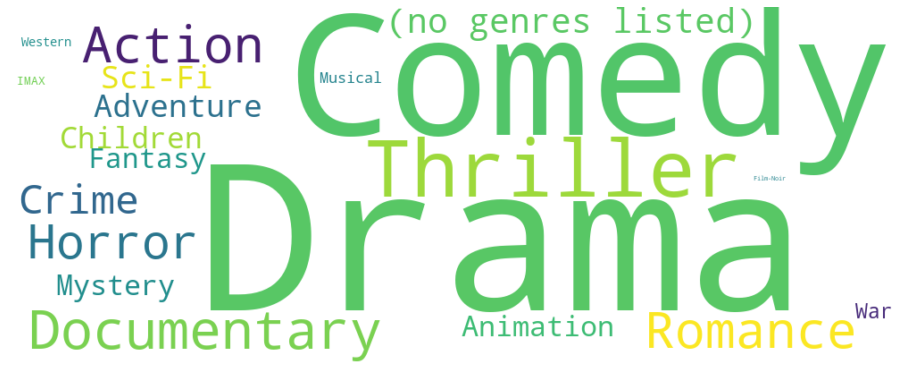

In [18]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(genre_frequency_list))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<font size="+1" color="red">Produce two word clouds: one for movies filmed before 2010, and another for movies filmed after 2010, and compare them. Do you notice any difference?</font>

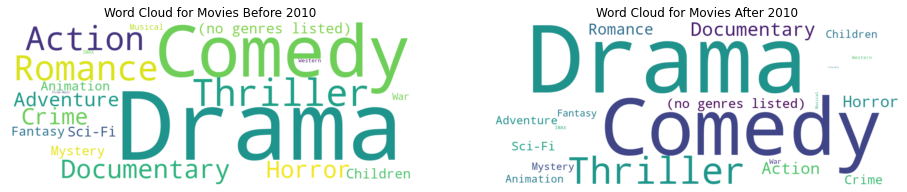

In [31]:
movies_before_2010 = movies[movies['title'].apply(yearof) < 2010]
movies_after_2010 = movies[movies['title'].apply(yearof) >= 2010]

all_genres = []
for genres in movies_before_2010['genres']:
    genre_list = genres.split('|')
    all_genres.extend(genre_list)
genre_counts = pd.Series(all_genres).value_counts()
genre_frequency_list_before = []
for genre, count in genre_counts.items():
    genre_frequency_list_before.append([genre, count])

wordcloud_before_2010 = WordCloud(width=1000, height=400, background_color='white')
wordcloud_before_2010.generate_from_frequencies(dict(genre_frequency_list_before))


all_genres = []
for genres in movies_after_2010['genres']:
    genre_list = genres.split('|')
    all_genres.extend(genre_list)

genre_counts = pd.Series(all_genres).value_counts()

genre_frequency_list_after = []
for genre, count in genre_counts.items():
    genre_frequency_list_after.append([genre, count])

wordcloud_after_2010 = WordCloud(width=1000, height=400, background_color='white')
wordcloud_after_2010.generate_from_frequencies(dict(genre_frequency_list_after))


# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_before_2010, interpolation="bilinear")
plt.title("Word Cloud for Movies Before 2010")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_after_2010, interpolation="bilinear")
plt.title("Word Cloud for Movies After 2010")
plt.axis('off')

plt.show()

I notice that there are two predominant genres that are Comedy and Drama, which are more popular after 2010 than before. The Romance and the Action genre were more popular before 2010, which makes sense because of the popularity of films like terminator or the fame of some actors like Sandra Bullock for the Romance genre. I can also observe that the Horror and Documentary genre stay similar, and after 2010 the popularity is less homogeneous than before.

# 3. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genres should have similar contents and therefore are more likely to be recommended.

We *could* extend the content-based taking into account the title or any other text-based characteristics of the movie. We could also extend it using other attributes of the movie, even if they are not text. Content-based recommendations just means that we somehow compute the similarity between the items and then recommend the most similar items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 3.1. Compute TF-IDF vectors

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 

TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the relevance of a word or term across different documents.

In a nutshell, TF-IDF weights infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres.

The TF-IDF score is computed as:

**tfidf(keyword, document) = TF(keyword, document) x IDF(keyword)**

Where:

* **TF(keyword, doc)** is the number of times the *keyword* appears in the *document*
* **IDF(keyword)** is **log(N/docfreq(keyword))** where **N** is the total number of documents and **docfreq(keyword)** is the number of documents containing the **keyword**

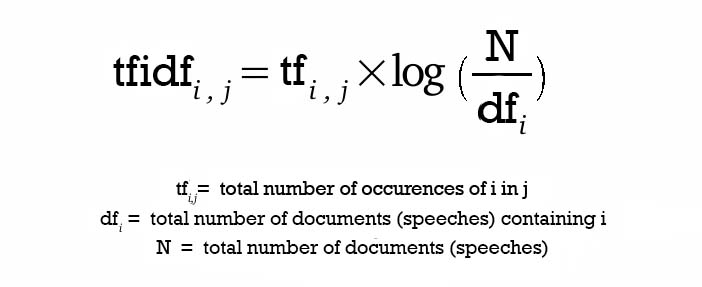

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

As a movie can belong to several genres, you should first break up the genre string into a string array.

Create a new column `genres_arr` in dataframe `movies` that contains the genres splitted in character "|".

Ensure this column has no "NaN", using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). Example: `df['colname'].fillna('').astype('str')`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

In [33]:
# Split the 'genres' column by '|' and store it in a new column 'genres_arr'
movies['genres_arr'] = movies['genres'].str.split('|')
# Replace any potential NaN values in the 'genres_arr' column with an empty list
movies['genres_arr'] = movies['genres_arr'].fillna('').astype('str')
# Display the updated dataframe
movies.head()

,movie_id,title,genres,year,genres_arr
0,2769,"Yards, The (2000)",Crime|Drama,2000,"['Crime', 'Drama']"
1,3177,Next Friday (2000),Comedy,2000,['Comedy']
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000,"['Adventure', 'Sci-Fi', 'Thriller']"
3,3225,Down to You (2000),Comedy|Romance,2000,"['Comedy', 'Romance']"
4,3228,Wirey Spindell (2000),Comedy,2000,['Comedy']


Verify by running the next cell. It should print:

```
Transformed: Comedy|Romance → ['Comedy', 'Romance']
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [34]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


Now we will work with a smaller part of the data. Define `movies_filtered` as all the movies filmed after 2015.

Use the [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute tf-idf vectors on this column. Use `ngram_range=(1,2)` to consider one- and two-word genres. Store the resulting vectors in `tfidf_matrix`.

The resulting matrix should have 7890 rows and 128 columns. Verify this using `tfidf_matrix.shape`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [96]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,['(no genres listed)']
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"['Action', 'Adventure', 'Fantasy']"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,['(no genres listed)']
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"['Action', 'Adventure', 'Sci-Fi']"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"


<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

In [97]:
# Create a TfidfVectorizer with ngram_range=(1, 2) and stop_words=None
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit and transform the 'genres_str' column to compute the TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_filtered['genres_arr'])

# Verify the shape of the resulting tfidf_matrix
print(tfidf_matrix.shape)

(7890, 130)


## 3.2. Calculate most similar movies

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.

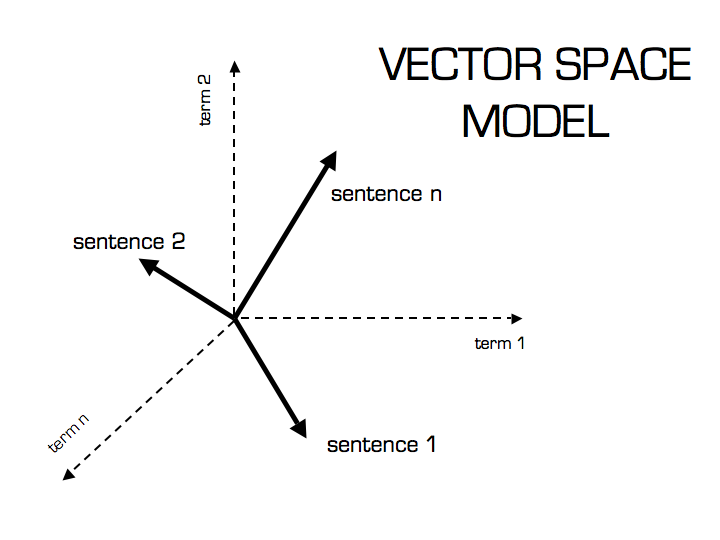

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [65]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


It is easy at this point to confuse movie_ids with row numbers. The following code, which you should leave as-is, will be helpful to you as it shows you how to obtain a row/column in this similarity matrix, and then how to go back to movie_ids from row/column numbers.

In this example, we ask for the similarities of all movies to movie with id 1 which is "Toy Story (1995)".

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [66]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.000 159059 The Midnight Man (2016)
0.000 159061 The Wailing (2016)
0.119 159065 Jai Gangaajal (2016)
0.087 159077 The Meddler (2016)
0.000 159085 Finding Mr. Right 2 (2016)
0.117 159093 Now You See Me 2 (2016)
0.000 159095 Southwest of Salem: The Story of the San Antonio Four (2016)
0.000 159097 The Apology (2016)
0.106 159099 The Masked Saint (2016)
0.000 159111 The Curse of Sleeping Beauty (2016)
0.000 159113 Highly Strung (2016)
0.000 159115 Chongqing Hot Pot (2016)
0.118 159153 The Land Before Time XIV: Journey of the Brave (2016)
0.238 159155 The Division: Agent Origins (2016)
0.000 159161 Ali Wong: Baby Cobra (2016)
0.087 159163 The Other Side of the Wind (2016)
0.000 159191 Julieta (2016)
0.057 159193 CafÃ© Society (2016)
0.000 159195 I, Daniel Blake (2016)
0.179 159221 Bad Guys Always Die (2016)
0.000 159223 The Pack (2016)
0.000 159249 Girls Lost (2016)
0.000 159261 The Yard (2016)
0.135 159263 Under the Pyramid (2016)
0.000 159273 ReykjavÃ­k (2016)
0.000 159313 Pyromaniac (

0.000 164145 The Neighbor (2016)
0.000 164149 Theo and Hugo (2016)
0.000 164161 Nina (2016)
0.000 164167 The Curse of Robert the Doll (2016)
0.178 164171 Jeremy (2016)
0.000 164173 Planetarium (2016)
0.000 164175 A Monster Calls (2016)
0.492 164179 Arrival (2016)
0.301 164181 Samurai Rauni Reposaarelainen (2016)
0.000 164187 Rumbos (2016)
0.051 164189 Traceroute (2016)
0.000 164196 I, Olga Hepnarova (2016)
0.044 164200 Storks (2016)
0.000 164204 After the Storm (2016)
0.000 164218 Hurok (2016)
0.178 164222 I am not Salvador (2016)
0.628 164226 Maximum Ride (2016)
0.178 164228 Radin ! (2016)
0.000 164236 Sieranevada (2016)
0.000 164238 Dogs (2016)
0.087 164260 Horace and Pete (2016)
0.000 164262 The Man from Mo'Wax (2016)
0.000 164264 Audrie & Daisy (2016)
0.178 164268 Iliza Shlesinger: Confirmed Kills (2016)
0.000 164280 Endless Poetry (2016)
0.000 164365 Level Up (2016)
0.266 164367 The Girl with All the Gifts (2016)
0.087 164369 The Distinguished Citizen (2016)
0.000 164373 Abattoir 

0.087 167732 A Street Cat Named Bob (2016)
0.296 167738 xXx: Return of Xander Cage (2017)
0.000 167740 The Bye Bye Man (2017)
0.000 167742 Blood on the Mountain (2016)
0.035 167744 Prevenge (2016)
0.115 167746 The Lego Batman Movie (2017)
0.000 167786 When the Bough Breaks (2016)
0.052 167790 The Good Boy (2016)
0.000 167794 Frantz (2016)
0.178 167800 Gabriel Iglesias: I'm Sorry for What I Said When I Was Hungry (2016)
0.000 167802 The 24 Hour War (2016)
0.178 167806 Ã fond (2016)
0.000 167814 A Wedding (2017)
0.000 167816 The Hollow (2016)
0.000 167818 Wizard Mode (2016)
0.178 167822 The Ideal (2016)
0.000 167832 The Invisible Guest (2016)
0.541 167838 Kung Fu Yoga (2016)
0.000 167840 Rangoon (2017)
0.670 167842 Death Race 2050 (2017)
0.178 167844 The Night My Mother Killed My Father (2016)
0.000 167848 Burn Country (2016)
0.385 167850 One Piece Film: GOLD (2016)
0.178 167854 Dana Carvey: Straight White Male, 60 (2016)
0.000 167856 Bright Lights: Starring Carrie Fisher and Debbie Rey

0.178 169358 Jena Friedman: American Cunt (2016)
0.178 169360 Wanda Sykes: What Happenedâ¦ Ms. Sykes? (2016)
0.178 169362 Barry Crimmins: Whatever Threatens You (2016)
0.178 169364 Janeane Garofalo: If I May (2016)
0.178 169366 Pete Davidson: SMD (2016)
0.178 169368 Mo Mandel: Negative Reinforcement (2016)
0.178 169370 Kathleen Madigan: Bothering Jesus (2016)
0.178 169372 Dan Levy: Lion (2016)
0.178 169374 Aries Spears: Comedy Blueprint (2016)
0.178 169376 Tony Roberts: Motorcity Motormouth (2016)
0.178 169378 Joey Coco Diaz: Sociably UnAcceptable (2016)
0.178 169380 Tom Papa: Human Mule (2016)
0.178 169382 Nick Thune: Good Guy (2016)
0.178 169384 Ian Harvie: May the Best Cock Win (2016)
0.000 169386 Ogres (2016)
0.178 169390 RAID Dingue (2017)
0.238 169392 Pre Vis Action (2016)
0.000 169394 My Entire High School Sinking Into the Sea (2016)
0.268 169400 Gantz: O (2016)
0.000 169406 Britney Ever After (2017)
0.000 169426 Indivisible (2016)
0.000 169428 Mr. Pig (2016)
0.000 169430 Siste

0.000 171023 The Hero (2017)
0.000 171031 Citizen Jane: Battle for the City (2016)
0.000 171037 Drain the Titanic (2016)
0.087 171043 Meet the Guilbys (2016)
0.000 171049 The Wall (2017)
0.087 171059 Panamerican Machinery (2016)
0.238 171061 Diamond Cartel (2017)
0.310 171071 Genocidal Organ (2017)
0.087 171083 Afterlov (2016)
0.000 171085 The Snare (2017)
0.000 171091 Only For One Night (2016)
0.274 171109 Phoenix Forgotten (2017)
0.087 171111 Skins (2017)
0.000 171113 The Immortal Life of Henrietta Lacks (2017)
0.000 171117 Boiling Point (2017)
0.301 171123 Burn Your Maps (2017)
0.000 171127 The Irresistible Blueberry Farm (2016)
0.000 171129 Tommy's Honour (2016)
0.000 171131 My Way: The Rise and Fall of Silvio Berlusconi (2016)
0.000 171141 Handsome Devil (2016)
0.000 171157 Lowriders (2017)
0.000 171165 Hell (2017)
0.299 171193 The Dark Tapes (2017)
0.000 171201 Mythica: The Godslayer (2016)
0.419 171207 Beyond Skyline (2017)
0.178 171209 Punching Henry (2017)
0.000 171225 Sam Was

0.371 173925 Seven Sisters (2017)
0.000 173931 7:19 (2016)
0.000 173933 The Son of Bigfoot (2017)
0.074 173935 Tokyo Ghoul (2017)
0.000 173939 On Body and Soul (2017)
0.000 173941 Atomic Blonde (2017)
0.000 173959 The Dreamed Ones (2016)
0.238 173975 God of War (2017)
0.000 174005 Aaron's Blood (2017)
0.000 174013 New Trial (2017)
0.000 174015 Saving Banksy (2017)
0.000 174017 The Exception (2017)
0.000 174033 The Killing Season (2016)
0.178 174045 Goon: Last of the Enforcers (2017)
0.063 174055 Dunkirk (2017)
0.238 174111 Bairavaa (2017)
0.000 174181 The Keepers (2017)
0.000 174365 The Summoning (2017)
0.107 174367 Go North (2017)
0.178 174371 Once Upon a Time in Venice (2017)
0.000 174373 Resurrecting Hassan (2016)
0.000 174377 For Love and Honor (2016)
0.000 174395 Better Watch Out (2016)
0.000 174403 The Putin Interviews (2017)
0.000 174407 An Inconvenient Sequel (2017)
0.419 174423 Rakka (2017)
0.238 174427 Savage Dog (2017)
0.119 174431 Jawbone (2017)
0.000 174435 Tear Me Apart (

0.000 176359 My Aunt in Sarajevo (2016)
0.000 176365 Below Her Mouth (2017)
0.492 176371 Blade Runner 2049 (2017)
0.000 176373 Armed Response (2017)
0.000 176375 Something Like Summer (2017)
0.139 176389 The Nut Job 2: Nutty by Nature (2017)
0.492 176391 Sharknado 5: Global Swarming (2017)
0.000 176403 The Divine Order (2017)
0.000 176405 Forever Pure (2016)
0.000 176419 Mother! (2017)
0.000 176423 Icarus (2017)
0.000 176425 Xuan Zang (2016)
0.000 176437 England Is Mine (2017)
0.000 176459 S Is for Stanley (2016)
0.000 176467 Respectable: The Mary Millington Story (2016)
0.297 176487 Marjorie Prime (2017)
0.000 176489 The Blind Christ (2016)
0.000 176515 Rage (2016)
0.000 176517 Venus (2016)
0.178 176519 Fun Mom Dinner (2017)
0.178 176521 The Layover (2017)
0.000 176523 Goodbye Christopher Robin (2017)
0.000 176533 My Happy Family (2017)
0.000 176545 mon mon mon MONSTERS (2017)
0.000 176551 The Limehouse Golem (2017)
0.352 176563 The Creature Below (2016)
0.299 176567 The Endless (2017

0.093 178517 Sniper: Ultimate Kill (2017)
0.000 178521 The Babysitter (2017)
0.000 178523 1922 (2017)
0.238 178527 Nitro Rush (2016)
0.178 178573 The Reunion 3: Baptism (2016)
0.087 178605 Tiger Theory (2016)
0.057 178615 Front Cover (2016)
0.000 178617 ÐÐ°Ð¿Ð°ÑÐ½Ð¸Ðº (2017)
0.064 178637 Date of the Dead (2017)
0.238 178639 Wolf Warrior 2 (2017)
0.000 178641 Chasing the Dragon (2017)
0.000 178645 Diana: In Her Own Words (2017)
0.000 178647 Girls in the Dark (2017)
0.066 178649 Wedding Unplanned (2017)
0.419 178651 Empire of the Sharks (2017)
0.000 178663 Restless Creature: Wendy Whelan (2017)
0.178 178665 ÐÐ°Ð±ÑÑÐºÐ° Ð»ÑÐ³ÐºÐ¾Ð³Ð¾ Ð¿Ð¾Ð²ÐµÐ´ÐµÐ½Ð¸Ñ (2017)
0.000 178667 Gerald's Game (2017)
0.087 178669 Daphne (2017)
0.000 178679 The Eternal Road (2017)
0.000 178693 Spettacolo (2017)
0.048 178707 Honnouji Hotel (2017)
0.000 178709 Naledi: A Baby Elephant's Tale (2016)
0.178 178713 Bomb Scared (2017)
0.088 178719 Shock Wave (2017)
0.337 178721 Distance Between Dreams (2016)
0.000 1

0.000 179977 In the Fade (2017)
0.143 179979 Heroes Above All (2017)
0.600 179981 The Veil (2017)
0.000 179983 Werk ohne Autor (2017)
0.000 179985 Romeo Is Bleeding (2017)
0.108 180017 Spyder (2017)
0.119 180031 The Shape of Water (2017)
0.000 180033 The Leisure Seeker (2017)
0.057 180035 Villaviciosa de al lado (2016)
0.000 180037 24 Hours to Live (2017)
0.000 180039 Most Beautiful Island (2017)
0.066 180041 Holy Camp! (2017)
0.178 180043 Suck Me Shakespeer 3 (2017)
0.000 180045 Molly's Game (2017)
0.000 180063 Wasteland No. 1: Ardent Verdant (2017)
0.178 180065 Three Summers (2017)
0.000 180069 Love and Goodbye and Hawaii (2017)
0.087 180073 The Fury (2016)
0.000 180075 The Connected Universe (2016)
0.000 180081 Oro (2017)
0.114 180091 PokÃ©mon the Movie: I Choose You! (2017)
0.492 180093 Singularity (2017)
0.000 180095 Wonder (2017)
0.000 180097 Christmas Crime Story (2017)
0.000 180099 The Big Bad Fox and Other Tales (2017)
0.310 180109 CzÅowiek z magicznym pudeÅkiem (2017)
0.000

0.058 182495 Father and Guns 2 (2017)
0.127 182547 Under an Arctic Sky (2017)
0.178 182549 Infinity Baby (2017)
0.178 182551 Mr. Roosevelt (2017)
0.044 182555 LEGO Jurassic World: Indominus Escape (2016)
0.043 182557 Psych: The Movie (2017)
0.000 182559 Dawson City: Frozen Time (2016)
0.054 182563 Golmaal Again (2017)
0.000 182581 The Cutlass (2017)
0.000 182585 Dementia 13 (2017)
0.178 182587 The Middle Finger (2016)
0.000 182589 Witchcraft 15: Blood Rose (2017)
0.000 182591 Witchcraft XIV: Angel of Death (2017)
0.000 182641 MisÃ©ricorde (2016)
0.000 182645 Last Rampage: The Escape of Gary Tison (2017)
0.000 182647 Dead Billy (2016)
0.000 182653 Dream Boat (2017)
0.000 182655 Witchcraft 16: Hollywood Coven (2017)
0.371 182657 Pale (2016)
0.000 182659 Once Upon a Time at Christmas (2017)
0.000 182661 I'll Be Home for Christmas (2016)
0.000 182667 Serpent (2017)
0.000 182671 Hired Gun (2016)
0.339 182673 The Carmilla Movie (2017)
0.000 182679 Christmas Inheritance (2017)
0.000 182681 Br

0.000 185111 Gangsta (2018)
0.000 185129 NiÃ±as AraÃ±a (2017)
0.000 185161 The Elf (2017)
0.000 185165 I babysitter (2016)
0.419 185167 Battle of the Drones (2017)
0.000 185169 The Strangers: Prey at Night (2018)
0.080 185171 The Hurricane Heist (2018)
0.000 185207 Germans & Jews (2016)
0.000 185229 The Bad Kids (2016)
0.000 185245 MartÃ­rio (2017)
0.087 185261 Number One (2017)
0.000 185263 Deaf child (2017)
0.088 185267 Paradox (2017)
0.000 185271 The Intruder (2017)
0.066 185285 Ice (2018)
0.000 185287 Nature Boy (2017)
0.000 185295 The Outsider (2018)
0.000 185303 The Dead Nation (2017)
0.000 185305 The Lullaby (2017)
0.000 185307 Far Cry 5: Inside Eden's Gate (2018)
0.000 185311 The Fixer (2016)
0.061 185313 Ð¯ ÑÑÐ´ÐµÑ (2018)
0.000 185315 Gauguin : Voyage de Tahiti (2017)
0.000 185317 The Empty Hands (2017)
0.258 185319 Prospect (2018)
0.000 185321 A River Below (2017)
0.000 185329 La tenerezza (2017)
0.000 185335 Bent (2018)
0.000 185337 Hans Zimmer: Live in Prague (2017)
0.00

0.000 186619 RÅ«ta (2018)
0.308 186625 Game of Aces (2016)
0.000 186631 Everybody Knows (2018)
0.178 186633 Sudani From Nigeria (2018)
0.000 186635 Meerkat Moonship (2018)
0.178 186639 Kuttanadan Marpappa (2018)
0.000 186641 Science Fair (2018)
0.087 186643 LavaKusha (2017)
0.087 186645 Sherlock Toms (2017)
0.178 186647 Varnyathil Aashanka (2017)
0.052 186649 DiwanjiMoola Grand Prix (2018)
0.178 186657 Anuraga Karikkin Vellam (2016)
0.132 186659 Carbon (2018)
0.000 186661 Hey Jude (2018)
0.052 186663 Njandukalude Naattil Oridavela (2017)
0.108 186665 Aadhi (2018)
0.052 186673 Adventures of Omanakuttan (2017)
0.000 186675 Ramaleela (2017)
0.178 186679 Parava (2017)
0.000 186689 Ramante Edanthottam (2017)
0.066 186691 Sunday Holiday (2017)
0.087 186695 Pavada (2016)
0.000 186699 Ezra (2017)
0.000 186701 Kochavva Paulo Ayyappa Coelho (2016)
0.000 186703 Oppam (2016)
0.000 186705 Ann Maria Kalippilaanu (2016)
0.000 186713 We've Forgotten More Than We Ever Knew (2017)
0.161 186719 Oru Mutha

0.000 188623 Burning (2018)
0.000 188625 Evil Genius: The True Story of America's Most Diabolical Bank Heist (2018)
0.403 188641 Pilgrimage (2017)
0.000 188643 The Battle Of Chosin (2016)
0.000 188645 Exorcism (2017)
0.000 188659 Little Woods (2018)
0.000 188663 Itzhak (2017)
0.000 188665 Last Days in Havana (2016)
0.039 188671 Glossary of Broken Dreams (2018)
0.000 188675 Dogman (2018)
0.363 188679 Fahrenheit 451 (2018)
0.178 188693 Once Upon a Time (2018)
0.000 188695 The Cleaners (2018)
0.000 188697 Happy as Lazzaro (2018)
0.000 188705 Girl in the Bunker (2018)
0.087 188709 Detours (2016)
0.179 188731 Taxi 5 (2018)
0.000 188747 The Adventure Club (2017)
0.080 188749 The Equalizer 2 (2018)
0.066 188751 Mamma Mia: Here We Go Again! (2018)
0.000 188753 Unfriended: Dark Web (2018)
0.000 188755 Little Star (2017)
0.000 188757 Generation Wealth (2018)
0.178 188759 Vishwa Vikhyatharaya Payyanma (2017)
0.000 188761 Puzzle (2018)
0.492 188765 Polish Legends: Operacja Bazyliszek (2016)
0.492 

0.000 190271 Broken (2016)
0.000 190287 Slender Man (2018)
0.000 190293 The Unthinkable (2018)
0.000 190299 I'm Drunk, I Love You (2017)
0.088 190305 A Prayer Before Dawn (2018)
0.000 190307 October (2018)
0.178 190309 Re Loca (2018)
0.000 190311 La omisiÃ³n (2018)
0.000 190313 The Scourge (2017)
0.000 190315 Las olas (2017)
0.000 190317 PraÃ§a Paris (2017)
0.178 190319 The Exchange (2017)
0.000 190321 Memoir of Pain (2018)
0.178 190323 Jalouse (2017)
0.087 190327 In Times of Fading Light (2017)
0.087 190329 Normandie nue (2018)
0.000 190331 Dhogs (2017)
0.042 190333 The Night of the Virgin (2016)
0.178 190335 Diane Has the Right Shape (2017)
0.000 190337 You Shall Not Sleep (2018)
0.000 190339 White Fang (2018)
0.178 190343 El mundo es suyo (2018)
0.066 190347 Foam Party! (2017)
0.087 190349 Juliet, Naked (2018)
0.089 190353 Tarak (2017)
0.066 190355 Rolling to You (2018)
0.057 190359 Dim the Fluorescents (2017)
0.000 190361 My Generation (2018)
0.000 190391 Axolotl Overkill (2017)
0.

0.000 192211 Wolf Girl and Black Prince (2016)
0.000 192213 Counterfeiting in Suburbia (2018)
0.178 192217 We Make Antiques! (2018)
0.178 192219 My Big Gay Italian Wedding (2018)
0.000 192223 The Apparition (2018)
0.000 192235 Life and Nothing More (2017)
0.178 192237 Hello Oksana Sokolova! (2018)
0.000 192239 Ernesto (2017)
0.000 192245 Bad Times at the El Royale (2018)
0.000 192247 Banshee Blacktop (2016)
0.000 192255 Santa & Andres (2016)
0.000 192257 Destiny: The Tale of Kamakura (2017)
0.079 192265 The Witch: Part 1. The Subversion (2018)
0.000 192273 Grace Jones: Bloodlight and Bami (2017)
0.000 192275 Farmlands (2018)
0.000 192279 Chavela (2017)
0.178 192283 Crazy Rich Asians (2018)
0.000 192285 Birds of Passage (2018)
0.000 192291 Rift (2017)
0.178 192301 Night Shift (2018)
0.312 192307 The Meg (2018)
0.000 192309 Sivalinga (2017)
0.066 192313 Making Out (2016)
0.064 192315 Slaughterhouse Rulez (2018)
0.000 192319 Operation Finale (2018)
0.117 192333 Maradona (2018)
0.277 19233

0.000 193479 Mercury 13 (2018)
0.119 193481 Rangasthalam (2018)
0.000 193483 A Loving Husband (2016)
0.000 193493 Jonathan (2016)
0.000 193495 Burn Your Name (2016)
0.000 193497 So auf Erden (2017)
0.000 193499 The City of the Future (2016)
0.178 193507 Where's The Money? (2017)
0.000 193509 How to Get Girls (2018)
0.178 193511 Public Disturbance (2018)
0.178 193515 An Almost Perfect Country (2016)
0.178 193521 Santa & Cie (2017)
0.119 193523 Bharat Ane Nenu (2018)
0.000 193525 Ossan's Love (2016)
0.085 193533 Bleach (2018)
0.000 193543 The Surrounding Game (2018)
0.000 193545 Primas (2017)
0.087 193547 Pet Names (2018)
0.000 193549 Anote's Ark (2016)
0.000 193559 Cargo (2017)
0.000 193561 55 Steps (2018)
0.000 193563 Gutland (2018)
0.000 193569 Enchanted Princess (2018)
0.298 193575 Another Time (2018)
0.000 193577 The Oslo Diaries (2018)
0.094 193581 Black Butler: Book of the Atlantic (2017)
0.040 193583 No Game No Life: Zero (2017)
0.000 193585 Flint (2017)
0.095 193587 Bungo Stray 

0.000 194772 The Witch in the Window (2018)
0.000 194777 The House of Violent Desire (2017)
0.000 194779 An American in Texas (2017)
0.178 194783 Ron White: If You Quit Listening, I'll Shut Up (2018)
0.000 194785 Living in the Future's Past (2018)
0.061 194787 Undercover Grandpa (2017)
0.000 194789 The End of Meat (2017)
0.108 194795 Middle Class Abbayi (2017)
0.000 194797 Godzilla: Eater of Stars (2018)
0.000 194799 Derren Brown: Sacrifice (2018)
0.000 194801 My Dinner With HervÃ© (2018)
0.000 194811 A Man is Dead (2018)
0.000 194815 Nirvana Island: The Last 47 Days (2016)
0.000 194819 The Super (2017)
0.000 194821 The Liberation of Skopje (2016)
0.362 194823 Genghis Khan (2018)
0.178 194827 Hotel Gagarin (2018)
0.324 194829 The Unseen (2016)
0.000 194831 Killer Kate! (2018)
0.000 194835 Without Me (2018)
0.087 194837 Batti Gul Meter Chalu (2018)
0.000 194843 9 Satra (2018)
0.000 194845 Delirium (2018)
0.000 194853 L7: Pretend We're Dead (2017)
0.000 194861 A Twelve-Year Night (2018)


0.179 196011 Agent Mr. Chan (2018)
0.348 196019 The Lotus (2018)
0.093 196021 The Quake (2018)
0.000 196023 Reaching Distance (2018)
0.000 196027 Damned Summer (2017)
0.166 196031 PeregrinaÃ§Ã£o (2017)
0.000 196035 Tell It to the Bees (2018)
0.085 196037 Monstrum (2018)
0.000 196039 On Your Wedding Day (2018)
0.000 196041 Gogol. A Terrible Vengeance (2018)
0.000 196047 The Toybox (2018)
0.000 196053 May the Devil Take You (2018)
0.000 196055 Girls Night Out (2017)
0.000 196057 Backgammon (2016)
0.000 196065 Permanent Green Light (2018)
0.127 196067 The Dawn Wall (2018)
0.000 196073 Tumbbad (2018)
0.000 196081 Ben Is Back (2018)
0.000 196087 Burn the Stage: The Movie (2018)
0.371 196093 Time Jumpers (2018)
0.087 196095 Swiped (2018)
0.000 196101 Alone We Fight (2018)
0.000 196103 Crested Ibis (2017)
0.000 196111 14 Cameras (2018)
0.000 196113 Kursk (2018)
0.000 196115 Prosecuting Evil: The Extraordinary World of Ben Ferencz (2018)
0.492 196117 Clara (2018)
0.000 196121 Hotel by the Rive

0.151 197557 Simmba (2018)
0.000 197559 FaÃ§ades (2017)
0.064 197565 Fanged Up (2017)
0.000 197573 Village Rockstars (2018)
0.532 197575 Thugs of Hindostan (2018)
0.348 197577 Megalodon (2018)
0.000 197579 Pledge (2019)
0.000 197585 Psychopaths (2017)
0.000 197591 A Dog's Way Home (2019)
0.000 197593 Elephants Can Play Football (2018)
0.075 197595 Pitbull: Last Dog (2018)
0.238 197597 K.G.F: Chapter 1 (2018)
0.057 197599 Zero (2018)
0.000 197601 Baazaar (2018)
0.000 197603 Belmonte (2018)
0.000 197605 The Dead Center (2018)
0.000 197611 Henchmen (2018)
0.238 197613 All the Devil's Men (2018)
0.121 197615 Santa Jaws (2018)
0.178 197617 The Troubleshooter (2018)
0.178 197623 Curmudgeons (2016)
0.075 197625 Ajin: Demi-Human (2017)
0.000 197629 Lifeboat (2018)
0.000 197659 Apocalypse After (2018)
0.000 197661 Fear Level (2018)
0.000 197663 Happy Death Day 2U (2019)
0.000 197665 Truth or Double Dare (2018)
0.000 197677 Into the Dark: Pooka! (2018)
0.000 197679 Backtrace (2018)
0.119 197681 

0.000 199512 Two Trams (2017)
0.000 199514 All the Colors of Giallo (2019)
0.000 199538 Leaving Neverland (2019)
0.000 199542 Bad Apple (2016)
0.000 199556 Home (2016)
0.000 199558 Divine Being : Essere Divina (2018)
0.000 199560 Bajo la rosa (2017)
0.000 199566 The Aftermath (2019)
0.000 199570 The Unwilling (2017)
0.087 199572 Love+Sling (2018)
0.000 199580 Maiden (2019)
0.000 199584 The Good Girls (2018)
0.000 199586 Midnight Traveler (2019)
0.000 199588 Styx (2019)
0.000 199592 Vultures (2018)
0.000 199594 Los Silencios (2019)
0.000 199596 Toni Morrison: The Pieces I Am (2019)
0.000 199610 Hutsul girl Ksenia (2019)
0.113 199622 Scooby-Doo! and the Curse of the 13th Ghost (2019)
0.000 199626 The Photographer of Mauthausen (2018)
0.000 199636 Meet the Trumps: From Immigrant to President (2017)
0.070 199642 Adanga Maru (2018)
0.358 199648 Kim Possible (2019)
0.000 199670 Strawberry Days (2017)
0.000 199672 Ouaga Girls (2017)
0.087 199674 The Unpromised Land (2019)
0.000 199676 What Wa

0.057 202249 Peach Girl (2017)
0.000 202251 Pink and Gray (2016)
0.057 202253 Signature Move (2017)
0.087 202255 Unlovable (2018)
0.000 202271 The Invisible Witness (2018)
0.000 202273 The Challenger Disaster (2019)
0.717 202275 Crazy Alien (2019)
0.179 202287 Pegasus (2019)
0.663 202289 Space Chicken (2017)
0.000 202293 John & Yoko: Above Us Only Sky (2018)
0.000 202305 In Embryo (2016)
0.000 202317 Ghost Town Anthology (2019)
0.000 202319 The Lies She Loved (2018)
0.060 202325 The Whistlers (2019)
0.238 202331 The Hard Way (2019)
0.087 202333 Funny story (2018)
0.000 202335 The Mystery of Henri Pick (2019)
0.000 202349 Stickman (2017)
0.000 202355 Puppet Master: Axis Termination (2017)
0.000 202357 A Brother (2018)
0.000 202359 Homecoming: A Film by BeyoncÃ© (2019)
0.075 202361 15 Minutes of War (2019)
0.178 202363 Kevin Hart: Irresponsible (2019)
0.076 202389 Kingdom (2019)
0.061 202391 Malibu Rescue (2019)
0.066 202393 Always Be My Maybe (2019)
0.000 202397 To the Ends of the World

0.000 203835 You Can't Watch This (2019)
0.057 203847 Kumbalangi Nights (2019)
0.000 203849 Ishq (2019)
0.000 203855 Saint Judy (2019)
0.000 203867 Carmine Street Guitars (2018)
0.075 203869 Saving Leningrad (2019)
0.054 203879 The Nobodies (2018)
0.178 203881 Aziz Ansari: RIGHT NOW (2019)
0.000 203886 Soul to Keep (2018)
0.178 203896 Streaker (2017)
0.000 203898 I Love You, Now Die: The Commonwealth Vs. Michelle Carter (2019)
0.087 203904 Blinded by the Light (2019)
0.000 203926 Five Million Dollar Life (2019)
0.000 203928 Echo in the Canyon (2019)
0.000 203930 Deadly Assistant (2019)
0.371 203934 Freaks (2019)
0.000 203936 Zombies (2019)
0.000 203938 China Not China (2018)
0.087 203940 Zeroville (2019)
0.000 203946 Real Love (2019)
0.143 203948 Kayak to Klemtu (2018)
0.000 203954 Take Me Somewhere Nice (2019)
0.000 203956 Soul Mate (2016)
0.000 203962 Go Back to China (2019)
0.000 203966 Kidnapping Stella (2019)
0.000 203972 ParchÃ­s: The Documentary (2019)
0.000 203974 Okko's Inn (2

0.000 205511 Present.Perfect. (2019)
0.000 205513 Angelo (2019)
0.000 205515 The Wild Goose Lake (2019)
0.178 205517 Harri Pinter, Drecksau (2017)
0.000 205523 13 Graves (2019)
0.000 205535 L'Isola di Medea (2016)
0.000 205537 Mon frÃ¨re (2019)
0.064 205539 Lupin the Third: Lie of Fujiko Mine (2019)
0.000 205545 Official Secrets (2019)
0.000 205559 Overcomer (2019)
0.000 205573 Travis Scott: Look Mom I Can Fly (2019)
0.000 205575 Angel of Mine (2019)
0.000 205583 Satanic Panic (2019)
0.066 205589 Suddenly Seventeen (2016)
0.178 205615 Como Se Tornar o Pior Aluno da Escola (2017)
0.066 205621 Can't Help Falling in Love (2017)
0.000 205661 Maleficent: Mistress of Evil (2019)
0.000 205665 Find Me (2018)
0.132 205667 Till the End of the World (2018)
0.000 205699 Nothing to Lose (2018)
0.000 205715 Reis (2017)
0.000 205749 Misbehavior (2017)
0.000 205765 Midori: The Camellia Girl (2016)
0.178 205767 Comrade Drakulich (2019)
0.000 205769 Dogs Don't Wear Pants (2019)
0.087 205773 Mektoub, My 

0.000 207167 Fragmentos de una amiga desconocida (2019)
0.178 207173 The Saint Bernard Syndicate (2018)
0.000 207187 Westside vs the World (2019)
0.031 207189 The Addams Family (2019)
0.492 207197 Collider (2018)
0.087 207203 La Vie scolaire (2019)
0.000 207209 Ravenswood (2017)
0.000 207211 American Exorcism (2017)
0.000 207213 The Traitor (2019)
0.178 207215 An Almost Ordinary Summer (2019)
0.064 207217 Ring Ring (2019)
0.060 207227 Harpoon (2019)
0.178 207229 Jexi (2019)
0.000 207231 Amy Winehouse: Back to Black (2018)
0.000 207235 Deadly Reunion (2019)
0.000 207239 Living Dark: The Story of Ted the Caver (2017)
0.178 207243 Deon Cole: Cole Hearted (2019)
0.000 207249 American Woman (2019)
0.178 207261 Tamizh Padam 2 (2018)
0.179 207263 Junga (2018)
0.119 207265 Dharmadurai (2016)
0.000 207269 The Magic Life of V (2019)
0.000 207273 The Collini Case (2019)
0.000 207277 Chained (2019)
0.000 207279 Peaches & Cream (2019)
0.492 207287 ami. exe (2017)
0.000 207289 Take Me to the Moon (2

Create a function `genre_content_based_recommendations` that uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie.

Python's `enumerate` function will be helpful. Look at the following example:

```python
similarities = [0.2, 0.7, 0.3, 0.4]
enumerated = list(enumerate(similarities))
sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
top_two_similarities = sorted_similarities[0:2]
for index, similarity in top_two_similarities:
    print("Element #%d with similarity %.1f" % (index, similarity))
```

The output will be: 

```
Element #1 with similarity 0.7
Element #3 with similarity 0.4
```

The function `genre_content_based_recommendations` should follow this template:

```python
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [78]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    # Calculate similarity scores for all movies
    sim_scores = list(enumerate(similarities[index_source]))

    # Sort the movies by similarity in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top `num_movies` most similar movies
    top_similarities = sim_scores[1:num_movies+1]  # Exclude the movie itself

    recommendations = []
    for (index_target, similarity) in top_similarities:

        # Get movie_id, title, and genres for the recommended movie
        movie_id = movies_filtered.iloc[index_target]['movie_id']
        title = movies_filtered.iloc[index_target]['title']
        genres = movies_filtered.iloc[index_target]['genres']

        recommendations.append({
            'movie_id': movie_id,
            'title': title,
            'genres': genres,
            'similarity': similarity
        })

    return pd.DataFrame(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

,similarity,movie_id,title,genres
0,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
1,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
2,1.0,138212,Spectral (2016),(no genres listed)
3,1.0,141131,Guardians (2016),(no genres listed)
4,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
5,1.0,150724,Army Dog (2016),(no genres listed)
6,1.0,151461,Fitoor (2016),(no genres listed)
7,1.0,151593,Martyrs (2016),(no genres listed)
8,1.0,152037,Grease Live (2016),(no genres listed)
9,1.0,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed)


<font size="+1" color="red">Replace this cell with code to print the top 10 recommendations for movie "Pirates of the Caribbean" (movie_id=122896) and "Midsommer" (movie_id=201646).</font>

In [82]:
#10 Recommendations for movie "Pirates of the Caribbean"
recommendations = genre_content_based_recommendations(122896, movies_filtered, cosine_sim, num_movies=10)
recommendations.head(10)

,similarity,movie_id,title,genres
0,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
1,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
2,1.0,138212,Spectral (2016),(no genres listed)
3,1.0,141131,Guardians (2016),(no genres listed)
4,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
5,1.0,150724,Army Dog (2016),(no genres listed)
6,1.0,151461,Fitoor (2016),(no genres listed)
7,1.0,151593,Martyrs (2016),(no genres listed)
8,1.0,152037,Grease Live (2016),(no genres listed)
9,1.0,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed)


In [83]:
#10 Recommendations for movie "Midsommer"
recommendations = genre_content_based_recommendations(201646, movies_filtered, cosine_sim, num_movies=10)
recommendations.head(10)

,similarity,movie_id,title,genres
0,1.000000,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
1,1.000000,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
2,1.000000,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
3,1.000000,184067,Without Name (2017),Drama|Horror|Mystery
4,1.000000,190755,The Little Stranger (2018),Drama|Horror|Mystery
5,1.000000,192291,Rift (2017),Drama|Horror|Mystery
6,1.000000,201646,Midsommar (2019),Drama|Horror|Mystery
7,1.000000,201739,Wounds (2019),Drama|Horror|Mystery
8,1.000000,202225,Something (2018),Drama|Horror|Mystery
9,0.856332,158619,The Faith of Anna Waters (2016),Drama|Horror|Mystery|Thriller


<font size="+1" color="red">Replace this cell with code to get the list of recommendation for three movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

In [93]:
#Now I indicate the precision of recommendations for films that I am familiar with
#Rebirth (2016)
recommendations = genre_content_based_recommendations(161312, movies_filtered, cosine_sim, num_movies=10)
recommendations.head(10)

,similarity,movie_id,title,genres
0,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
1,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
2,1.0,138212,Spectral (2016),(no genres listed)
3,1.0,141131,Guardians (2016),(no genres listed)
4,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
5,1.0,150724,Army Dog (2016),(no genres listed)
6,1.0,151461,Fitoor (2016),(no genres listed)
7,1.0,151593,Martyrs (2016),(no genres listed)
8,1.0,152037,Grease Live (2016),(no genres listed)
9,1.0,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed)


In this list the precision is 7/10 = 0.7

In [94]:
#Justice League: Dawn of Apokolips (2017)
recommendations = genre_content_based_recommendations(205815, movies_filtered, cosine_sim, num_movies=10)
recommendations.head(10)

,similarity,movie_id,title,genres
0,1.0,157326,Bastille Day (2016),Action
1,1.0,158402,The Crew (2016),Action
2,1.0,159155,The Division: Agent Origins (2016),Action
3,1.0,159484,Life on the Line (2016),Action
4,1.0,160169,The Asian Connection (2016),Action
5,1.0,160438,Jason Bourne (2016),Action
6,1.0,160684,Marauders (2016),Action
7,1.0,160956,Code of Honor (2016),Action
8,1.0,161068,Countdown (2016),Action
9,1.0,161290,Vigilante Diaries (2016),Action


In this list the precision is 6/10 = 0.6

In [95]:
#The Lying Detective (2017)
recommendations = genre_content_based_recommendations(205399, movies_filtered, cosine_sim, num_movies=10)
recommendations.head(10)

,similarity,movie_id,title,genres
0,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
1,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
2,1.0,138212,Spectral (2016),(no genres listed)
3,1.0,141131,Guardians (2016),(no genres listed)
4,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
5,1.0,150724,Army Dog (2016),(no genres listed)
6,1.0,151461,Fitoor (2016),(no genres listed)
7,1.0,151593,Martyrs (2016),(no genres listed)
8,1.0,152037,Grease Live (2016),(no genres listed)
9,1.0,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed)


Finally, in this list the precision is 3/10 = 0.4. In this case I do not think that the recommendations were really similar like the film I introduced.

The average precision among the three is: (0.7 + 0.6 + 0.4) / 3 = 0.57

The average precision shows that slightly more than the half of the films recommended were considered relevant by myself, and it is a good amount per each block of recommendations, but there there could be an improvement of the algorithm in order to create more accurate recomendations.

<font size="+1" color="red">Replace this cell with ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

The first idea that I think it would imrove this content-based recommendations is to extract more meaningful features from the movie data, such as the director, actors, release year, and keywords from the movie description. Another idea would be using a more extensive and standardized genre taxonomy to capture finer-grained genre information where we could incorporate user-defined genres to allow users to specify their preferences in a more detailed way. And finally I think that applying dimensionality reduction techniques, (PCA for example), to reduce the dimensionality of the feature space would also improve the recomendations.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, use the user-defined tags defined in the `tags-2000.csv` file, in the same way in which you used movie genres. Feel free to filter aggressively if necessary (e.g., to impose a minimum document frequency when doing the tf-idf vectorization).

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: tags</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>